In [16]:
# Import modules:
import sys
import gmsh
import matplotlib.pyplot as plt
import numpy as np

In [17]:
# Simple 2d geometry:
#          D----C
#         /     |                 D1 | D2
#  F-----E      |   -> subdomains -------
#  |            |                 D3 | D4
#  A------------B
h = 2
x_down = 15
x_slope = 10
x_up = 15
y_down = 10
y_slope = 10
x_sum = x_down + x_slope + x_up
y_sum = y_down + y_slope

In [18]:
# Initialize gmsh:
gmsh.initialize()
factory = gmsh.model.occ

# Corner points:
A = factory.add_point(0, 0, 0)
B = factory.add_point(x_sum, 0, 0)
C = factory.add_point(x_sum, y_sum, 0)
D = factory.add_point(x_down+x_slope, y_sum, 0)
E = factory.add_point(x_down, y_down, 0)
F = factory.add_point(0, y_down, 0)

# Boundary segments:
AB = factory.add_line(A, B)
BC = factory.add_line(B, C)
CD = factory.add_line(C, D)
DE = factory.add_line(D, E)
EF = factory.add_line(E, F)
FA = factory.add_line(F, A)

ABCDEF = factory.add_curve_loop([AB, BC, CD, DE, EF, FA])
factory.add_plane_surface([ABCDEF], tag=1234)

# Circular section:
r = y_sum*2/3
G = factory.add_point(x_sum-r, 0, 0, meshSize=h)
H = factory.add_point(x_sum, r, 0, meshSize=h)
HG = factory.addCircleArc(G, B, H)
GB = factory.add_line(G, B)
BH = factory.add_line(B, H)
BHG = factory.add_curve_loop([BH, HG, GB])
factory.add_plane_surface([BHG], tag=24)

# The simple construction above can be combined with OCC tools
factory.add_rectangle(0, 0, 0, x_sum, y_down/2, tag=34)  # OCC rectange

# The four subdomains can be created from overlap surfaces defined above
factory.cut([(2, 1234)], [(2, 34)], removeTool=False, tag=12)
factory.intersect([(2, 12)], [(2, 24)], removeObject=False, removeTool=False, tag=2)
factory.cut([(2, 12)], [(2, 2)], removeTool=False, tag=1)
factory.cut([(2, 34)], [(2, 24)], removeObject=False, removeTool=False, tag=3)
factory.intersect([(2, 34)], [(2, 24)], tag=4)

factory.extrude(factory.get_entities(2), 0, 0, 5)

# Synchronize and generate mesh:
factory.remove_all_duplicates()
factory.synchronize()
gmsh.model.mesh.setSize(gmsh.model.getEntities(0), h)
gmsh.model.mesh.generate()
gmsh.model.mesh.remove_duplicate_nodes()
gmsh.model.mesh.remove_duplicate_elements()

# Write mesh data to file:
# gmsh.write("GFG.msh")

# Create graphical user interface
# if 'close' not in sys.argv:
#     gmsh.fltk.run()

# Get node coordinates:
nodeTags, nodeCoords, nodeParams = gmsh.model.mesh.getNodes()

# Get (triangular) faces:
faceTypes, faceTags, faceNodeTags = gmsh.model.mesh.getElements(dim=2)

# Get (tetrahedral) elements:
elemTypes, elemTags, elemNodeTags = gmsh.model.mesh.getElements(dim=3)

# Extract X-, Y-, and Z- coordinates of all nodes from GMSH outputs:
node = np.array(nodeCoords)
node_X = node[0::3]
node_Y = node[1::3]
node_Z = node[2::3]

# All (tetrahedral) elements:
elem = elemNodeTags[0].reshape(-1, 4)
elem = elem-1  # indexing from 0

# All (triangular) faces on the boundary (including subdomains):
face = faceNodeTags[0].reshape(-1, 3)
face = face-1  # indexing from 0

# Subdomain tags for each element:
n_elem = elem.shape[0]
min_elemTag = min(elemTags[0])
material = np.zeros((n_elem,), dtype=int)
for i in range(4):
    _, tags, _ = gmsh.model.mesh.getElements(dim=3, tag=i+1)
    material[tags[0]-min_elemTag] = i+1

# Finalize the Gmsh API
gmsh.finalize()

Info    : Meshing 1D...nts                                                                                                                         
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 20%] Meshing curve 5 (Line)
Info    : [ 20%] Meshing curve 6 (Line)
Info    : [ 20%] Meshing curve 7 (Line)
Info    : [ 20%] Meshing curve 8 (Line)
Info    : [ 30%] Meshing curve 9 (Line)
Info    : [ 30%] Meshing curve 10 (Line)
Info    : [ 30%] Meshing curve 11 (Line)
Info    : [ 30%] Meshing curve 12 (Line)
Info    : [ 40%] Meshing curve 13 (Line)
Info    : [ 40%] Meshing curve 14 (Line)
Info    : [ 40%] Meshing curve 15 (Circle)
Info    : [ 40%] Meshing curve 16 (Circle)
Info    : [ 50%] Meshing curve 17 (Line)
Info    : [ 50%] Meshing curve 18 (Line)
Info    : [ 50%] Meshing curve 19 (Line)
Info    : [ 50%] Meshing curve 20 (Line)
Info    : [ 60%] Meshing curve 21 (Li

Text(0.5, 0.92, 'All faces on the boundary (including subdomains)')

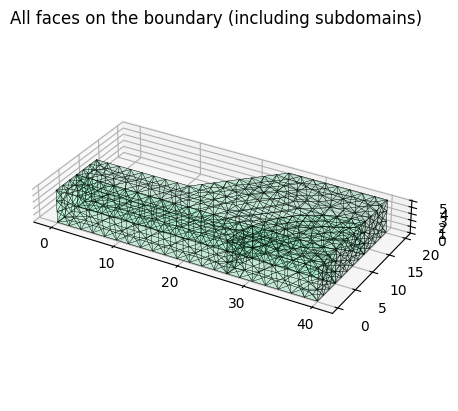

In [19]:
import matplotlib.pyplot as plt

ax = plt.axes(projection='3d')
ax.plot_trisurf(node_X, node_Y, node_Z, triangles=face, linewidths=0.2, edgecolor='k', color=[0, 1.0, 0.5, 0.1])
ax.set_aspect('equal')
ax.set_title("All faces on the boundary (including subdomains)")

Text(0.5, 0.92, 'All elements')

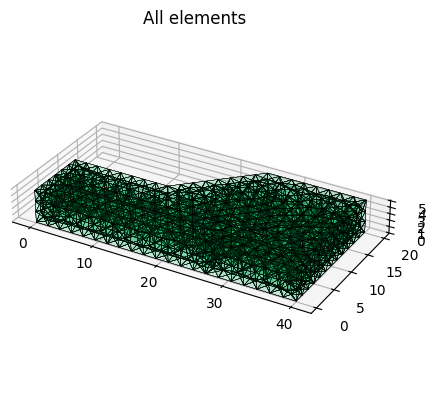

In [20]:
plt.figure()
ax = plt.axes(projection='3d')
for i in range(4):
    triangles = np.delete(elem,i,axis=1)
    ax.plot_trisurf(node_X, node_Y, node_Z, triangles=triangles, linewidths=0.2, edgecolor='k', color=[0, 1.0, 0.5, 0.05])
ax.plot_trisurf(node_X, node_Y, node_Z, triangles=face, linewidths=0.2, edgecolor='k', color=[0, 1.0, 0.5, 0.05])
ax.set_aspect('equal')
ax.set_title("All elements")